#1 - Implementing the model





In [20]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from fastai.data.external import untar_data, URLs
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [21]:
#!pip install fastai --upgrade

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
from matplotlib.colors import ListedColormap
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))
#CHANGE TO YOUR DIRECTORY
#image_path = r'/content/drive/MyDrive/carseg_data/carseg_data/images/black_5_doors/no_segmentation'
#segmentation_path = r'/content/drive/MyDrive/carseg_data/carseg_data/images/black_5_doors/with_segmentation'
array_path = r'/content/drive/MyDrive/carseg_data/arrays3.0/arrays'
#CMAP for our segmentation
car_cmap = ListedColormap([
(0,0,0),
(250, 149, 10), (19, 98, 19), (249, 249, 10),
(10, 248, 250), (149, 7, 149), (5, 249, 9),
(20, 19, 249), (249, 9, 250),(0,0,0)
])

'''
image_files = sorted(os.listdir(image_path))[:1]
segmentation_files = sorted(os.listdir(segmentation_path))[:1]
i = 1
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
for image_file, segmentation_file in zip(image_files, segmentation_files):
    image_file_path = os.path.join(image_path, image_file)
    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)

    # Load and display the image
    img = Image.open(image_file_path)
    plt.subplot(2, 5, image_files.index(image_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'5 door no seg')

    # Load and display the segmentation mask
    seg_mask = Image.open(segmentation_file_path)
    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)
    plt.imshow(seg_mask)
    plt.axis('off')
    plt.title(f'5 door seg')

    i +=1
plt.colorbar()
plt.show()
'''

Checking existence  None


"\nimage_files = sorted(os.listdir(image_path))[:1]\nsegmentation_files = sorted(os.listdir(segmentation_path))[:1]\ni = 1\nfig, axs = plt.subplots(2, 1, figsize=(20, 8))\nfor image_file, segmentation_file in zip(image_files, segmentation_files):\n    image_file_path = os.path.join(image_path, image_file)\n    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)\n\n    # Load and display the image\n    img = Image.open(image_file_path)\n    plt.subplot(2, 5, image_files.index(image_file) + 1)\n    plt.imshow(img)\n    plt.axis('off')\n    plt.title(f'5 door no seg')\n\n    # Load and display the segmentation mask\n    seg_mask = Image.open(segmentation_file_path)\n    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)\n    plt.imshow(seg_mask)\n    plt.axis('off')\n    plt.title(f'5 door seg')\n\n    i +=1\nplt.colorbar()\nplt.show()\n"

In [24]:
import os
import numpy as np
from torch.utils.data import Dataset

class NumpyArrayDataset(Dataset):
    def __init__(self, array_dir):
        self.array_dir = array_dir
        self.array_files = os.listdir(array_dir)

    def __len__(self):
        return len(self.array_files)

    def __getitem__(self, idx):
        array_filename = self.array_files[idx]
        array_path = os.path.join(self.array_dir, array_filename)

        # Load the numpy array
        numpy_array = np.load(array_path)

        # Assuming the array contains 4 channels (RGB + segmentation)
        # Split the array into RGB and segmentation channels
        rgb_channels = numpy_array[:, :, :3]  # Extract RGB channels
        segm_channel = numpy_array[:, :, 3]   # Extract segmentation channel

        # Convert to PyTorch tensors
        rgb_channels_tensor = torch.from_numpy(rgb_channels.transpose(2, 0, 1)).float()
        segm_channel_tensor = torch.from_numpy(segm_channel).long()

        # Return a dictionary containing the RGB and segmentation channels
        return {'car': rgb_channels_tensor, 'segm_mask': segm_channel_tensor}



In [25]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# Directory containing the numpy arrays
batch_size = 4
# Create an instance of the NumpyArrayDataset
numpy_dataset = NumpyArrayDataset(array_path)

train_dataset_np, val_dataset_np = train_test_split(numpy_dataset, train_size=0.9, random_state=42)

# Create data loaders with the custom collate function
train_dl_np = DataLoader(train_dataset_np, batch_size=batch_size, shuffle=True, num_workers=2)
val_dl_np = DataLoader(val_dataset_np, batch_size=batch_size, shuffle=True, num_workers=2)

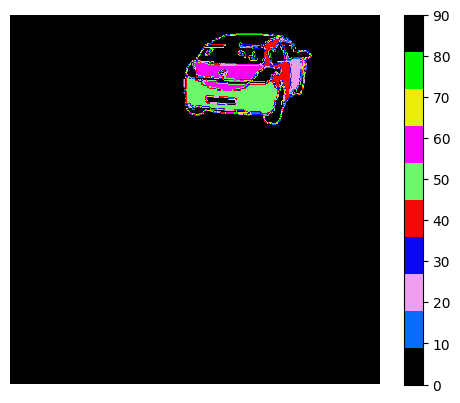

In [26]:
data = next(iter(train_dl_np))
seg_mask_tensor = data['segm_mask'][2]  # Select the third segmentation mask

# Convert the PyTorch tensor to a NumPy array
seg_mask_numpy = seg_mask_tensor.numpy()

# Display the segmentation mask'
plt.imshow(seg_mask_numpy, cmap=car_cmap)  # Assuming the segmentation mask has a single channel
plt.axis('off')
plt.colorbar()
plt.show()

#Disregard the edge noise, fix later

In [27]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2, inplace=True)
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):
        if self.outermost:
            output = self.model(x)
            return output
        else:
            x_clone = x.clone()
            residual_output = self.residual(x_clone)
            model_output = self.model(x)
            concatenated_output = torch.cat([residual_output, model_output], 1)
            return concatenated_output


class Unet(nn.Module):
    def __init__(self, input_c=3, output_c=10, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):

        #out = (0.5 - 1e-7) * torch.erf(self.model(x)/torch.sqrt(torch.tensor(2)))
        #out = nn.Softmax(dim=1)(self.model(x))
        out = self.model(x)
        return  out


##Weights
We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article

In [28]:
def init_weights(net, init='norm', gain=0.1, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='xavier', gain=0.02):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model


## Dice Loss

In [29]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-8  # Smoothing value to prevent division by zero
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_coeff = (2.0 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1.0 - dice_coeff
        return dice_loss


##Cross-Entropy Loss

In [30]:
class CustomCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()

    def forward(self, output, target):
        batch_size, num_classes, height, width = output.size()

        # Reshape the output tensor to (batch_size * height * width, num_classes)
        output_reshaped = output.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)

        # Flatten the target tensor to (batch_size * height * width,)
        target_flat = target.view(-1)

        # Use gather to extract the predicted scores for the target classes
        scores = torch.gather(output_reshaped, 1, target_flat.unsqueeze(1))

        # Reshape the scores tensor back to (batch_size, height, width)
        scores = scores.view(batch_size, height, width)

        # Calculate cross-entropy loss
        loss = -torch.log(scores.clamp(min=1e-8))  # Clamp to prevent log(0)
        return loss.mean()

## Main model

In [31]:
import sys
import torch.nn.functional as F

np.set_printoptions(threshold=np.inf)
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=3e-5,
                 beta1=0.9, beta2=0.9, lambda_L1=1):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=3, output_c=10, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))

        self.LossFunction = nn.CrossEntropyLoss()  # Change loss function for segmentation

    def set_requires_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = True

    def setup_input(self, data):
        self.car = data['car'].to(self.device)
        self.segm_mask = data['segm_mask'].to(self.device)

    def forward(self):

        self.predicted_segm_mask = self.net_G(self.car)

    def backward_G(self):
        self.segm_mask = self.segm_mask / 10
        self.seg_loss = self.LossFunction(self.predicted_segm_mask.type(torch.FloatTensor),self.segm_mask.type(torch.LongTensor))
        self.total_loss = self.seg_loss * self.lambda_L1


        self.opt_G.zero_grad()
        self.total_loss.backward()
        self.opt_G.step()

    def optimize(self):
        self.forward()
        self.opt_G.zero_grad()
        self.net_G.train()
        self.backward_G()
        self.opt_G.step() #Double step, check if needed



The MeasureClass class is a utility class for computing and tracking the average of a value over multiple iterations. It keeps track of the count, sum, and average of the values. The reset method resets the meter, while the update method updates the meter with a new value and count.



## Measures

In [32]:
#pip install tensorboard

In [33]:
from torch.utils.tensorboard import SummaryWriter
class MeasureClass:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    total_loss = MeasureClass()

    return {
            'total_loss': total_loss}

def update_losses(model, loss_meter_dict, count, writer, step):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        writer.add_scalar(loss_name, loss_meter.avg, step)

def log_results(loss_meter_dict, step, writer, num_epoch):
    for loss_name, loss_meter in loss_meter_dict.items():
        l_avg = loss_meter.avg
        print(f"{loss_name}: {l_avg:.2f}")
        writer.add_scalar(loss_name, loss_meter.avg, step)

def plot_results(loss_list, num_epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), loss_list, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Total Loss Over Epochs')
    plt.legend()
    plt.show()

##1.8- Training function


In [34]:
#Loss plot section
loss_list = []

model initialized with xavier initialization


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  1


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  6


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  7


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  8


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  9


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  10


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  11


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  12


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  13


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  14


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  15


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  16


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  17


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  18


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  19


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  20


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  21


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  22


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  23


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  24


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  25


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  26


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  27


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  28


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  29


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  30


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  31


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  32


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  33


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  34


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  35


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  36


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  37


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  38


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  39


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  40


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  41


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  42


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  43


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  44


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  45


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  46


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  47


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  48


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  49


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  50


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  51


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  52


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  53


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  54


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  55


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  56


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  57


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  58


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  59


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  60


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  61


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  62


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  63


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  64


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  65


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  66


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  67


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  68


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  69


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  70


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  71


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  72


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  73


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  74


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch  75


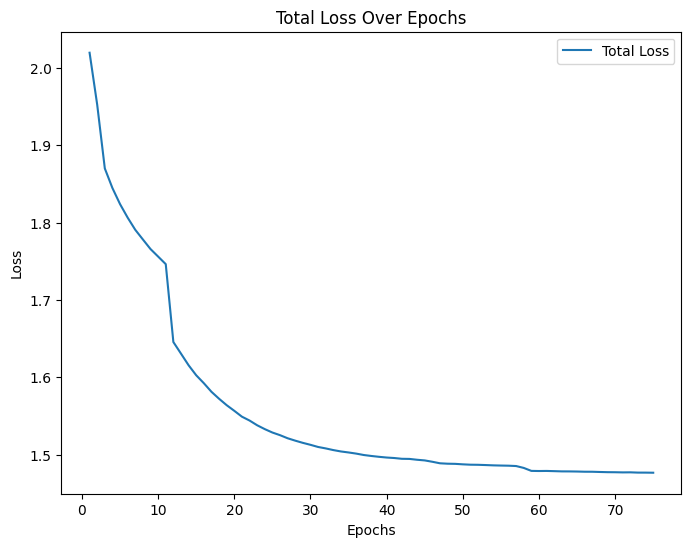

In [37]:

def train_model(model, train_loader, val_loader, epochs, display_every=200):
    writer = SummaryWriter()
    step = 0


    total_losses = []
    for epoch in range(1, epochs + 1):
        loss_meter_dict = create_loss_meters()
        i = 0
        avg_loss_list = []
        for data in tqdm(train_loader):
            model.set_requires_grad()
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['car'].size(0), writer=writer, step=step)
            i += 1
            step += 1
            for loss_name, loss_meter in loss_meter_dict.items():
                l_avg = loss_meter.avg
            avg_loss_list.append(l_avg)
            log_results(loss_meter_dict, step, writer, epoch)
        loss_list.append(sum(avg_loss_list)/len(avg_loss_list))
        print('Epoch ', epoch)
    # Collect total losses for plotting

    writer.close()


model = MainModel()
num_epochs = 75
train_model(model, train_dl_np, val_dl_np, num_epochs)
plot_results(loss_list, num_epochs)
loss_list = [] #clear the list after execution

###Preparing the test dataset

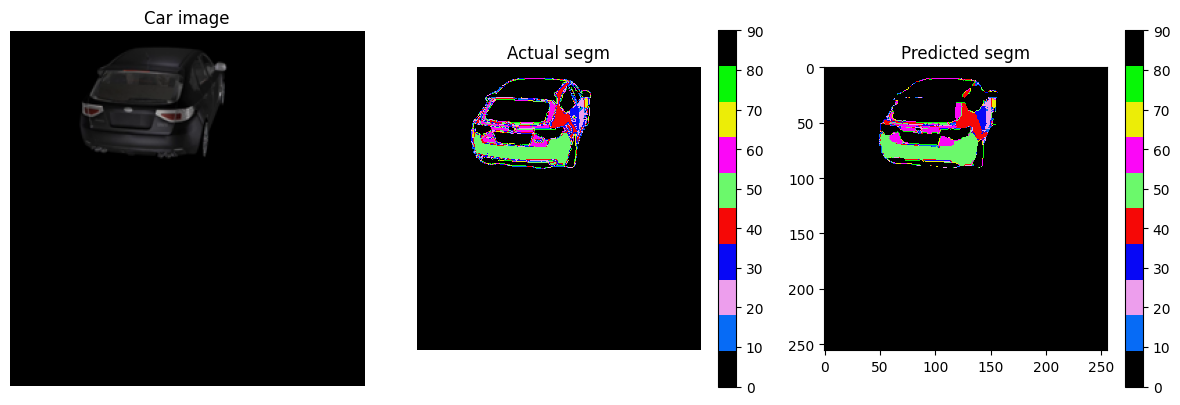

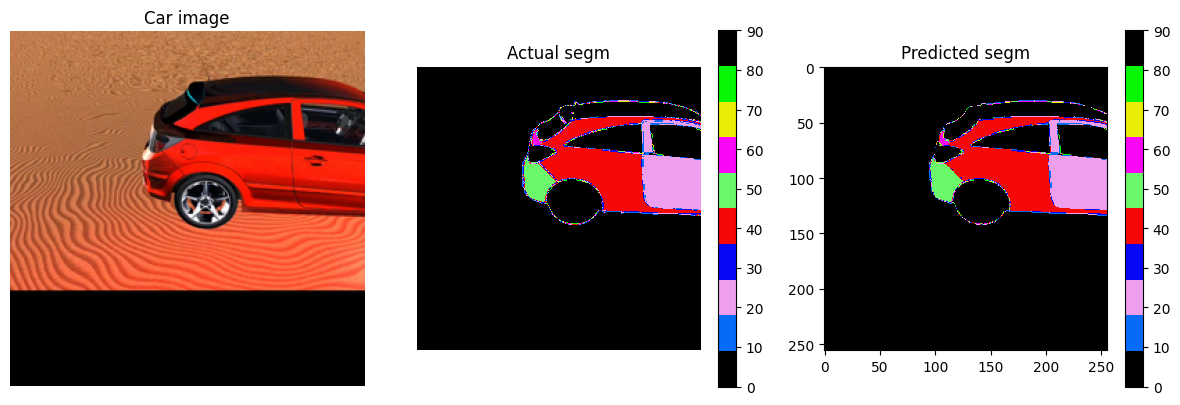

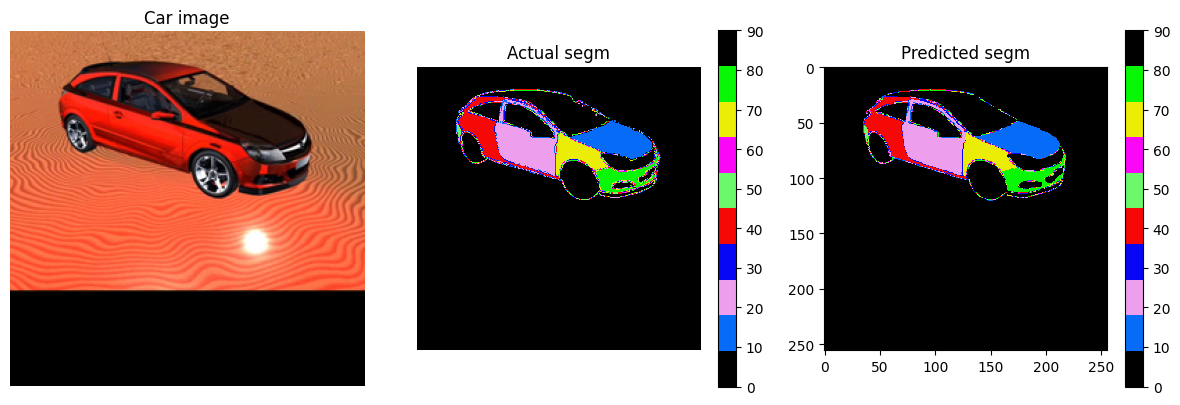

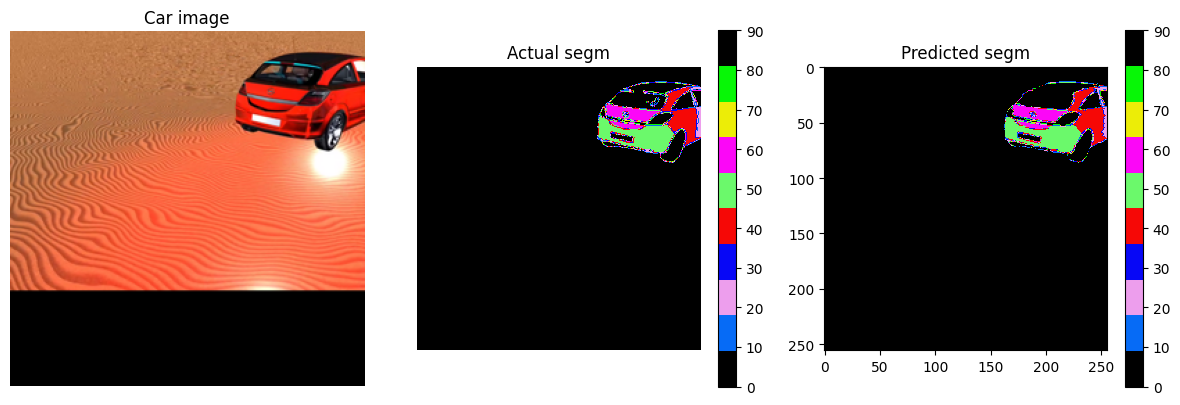

IndexError: ignored

In [38]:
import matplotlib.pyplot as plt
def visualize_segmentation(model, valid_dl, num_samples=5):
    model.eval()  # Set model to evaluation mode

    sample_iterator = iter(valid_dl)

    data = next(sample_iterator)
    for i in range(8):
        car_scans = data['car'][i].cpu().numpy() # Assuming your model device is set correctly
        # Forward pass
        model.car = data['car'].cuda()
        model.forward()
        segms = data['segm_mask'][i].cpu().numpy()
        # Get predicted masks (assuming you've used sigmoid activation in your model)
        predicted_masks = model.predicted_segm_mask[i].cpu().detach().numpy()

        plt.figure(figsize=(12, 4))

        # Display the original CT scan image
        plt.subplot(1, 3, 1)
        plt.title('Car image')
        plt.imshow(car_scans.transpose(1,2,0).astype(np.uint8))  # Assuming grayscale CT scans
        plt.axis('off')

        # Display the actual segmentation mask
        plt.subplot(1, 3, 2)
        plt.title('Actual segm')
        plt.imshow(segms,cmap=car_cmap)  # Assuming grayscale masks
        plt.colorbar()
        plt.axis('off')

        # Display the predicted segmentation mask
        plt.subplot(1, 3, 3)
        plt.title('Predicted segm')
        predicted_masks = np.argmax(predicted_masks,axis = 0)*10
        plt.imshow(predicted_masks,cmap=car_cmap)  # Assuming grayscale masks
        plt.axis('on')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# Usage
visualize_segmentation(model, val_dl_np, num_samples=5)

